=== OPTIMIZATION SETTINGS ===
Smart Padding: True
Use Momentum: True
Adaptive LR: True
Quality Weighting: True
Rank-Based Expect Rank: 8

Client label sets: [[2, 8], [3, 5], [0, 1], [3, 6], [0, 4], [6, 8], [0, 1], [1, 3], [1, 2], [0, 3]]
Client sample sizes: [7000, 7000, 7000, 6800, 6266, 5733, 5200, 4666, 4133, 3600]
Client ranks: [2, 4, 8, 4, 2, 8, 4, 2, 8, 4]
=== Running: zero_pad_product_sum (Optimized) ===
Zero Pad (Optimized) - Using 10 clients with weights: ['0.1246', '0.0924', '0.1412', '0.1309', '0.0899', '0.1031', '0.1039', '0.0854', '0.0768', '0.0519']
[zero_pad_product_sum] Round 01  Test Acc (NO finetune) = 22.18%
Zero Pad (Optimized) - Using 10 clients with weights: ['0.1150', '0.1087', '0.1279', '0.1227', '0.1125', '0.1006', '0.0949', '0.0829', '0.0713', '0.0634']
[zero_pad_product_sum] Round 02  Test Acc (NO finetune) = 22.70%
Zero Pad (Optimized) - Using 10 clients with weights: ['0.1171', '0.1109', '0.1253', '0.1239', '0.1139', '0.1009', '0.0958', '0.0783', '0.0706', 

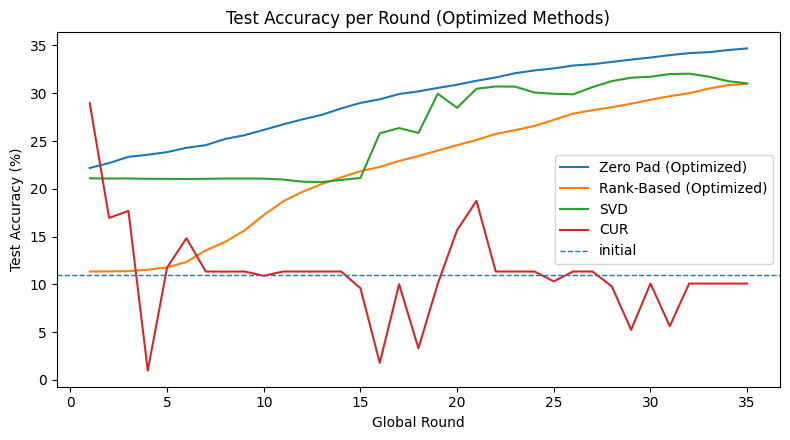

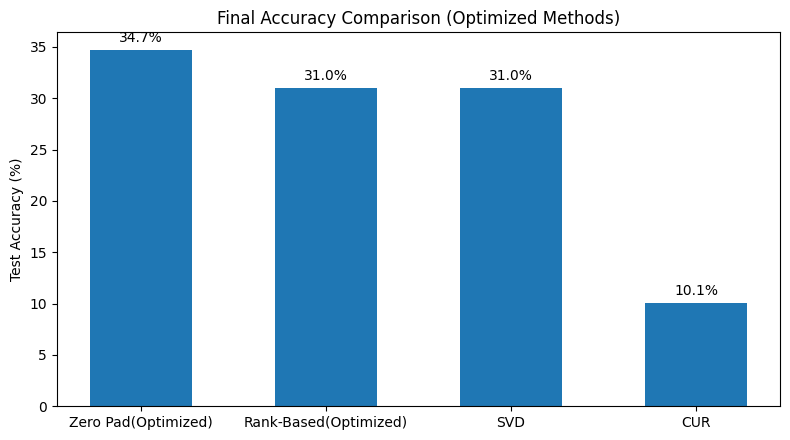

In [1]:
# -*- coding: utf-8 -*-
# Federated LoRA on MNIST — Optimized Zero-Pad, Rank-Based, SVD and CUR methods
# Optimizations: Smart padding, rank selection, adaptive learning rates, momentum

import torch, random, copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
CFG = dict(
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu",

    # Clients & data
    num_clients=10,
    classes_per_client=2,          # Non-IID: labels per client
    batch_size=256,
    max_items_per_client=7000,     # cap per-client samples for runtime

    # Non-IID & "double-imbalance" (probabilistic)
    double_imbalance=True,

    # Training (NO pretrain)
    base_pretrain_epochs=0,        # keep 0 per teacher
    base_lr=1e-3,
    local_epochs=2,
    lr_local=2e-3,
    weight_decay=1e-4,
    global_rounds=35,

    # LoRA
    alpha=16,
    client_ranks=[2,4,8,4,2,8,4,2,8,4],   # ranks for the 10 clients
    target_rank=8,                        # global/aggregation target rank

    # Rank-based settings - OPTIMIZED: Choose higher rank
    rank_based_expect_rank=8,  # Changed from 4 to 8 for better capacity

    # NO finetune (per your request)
    do_finetune=False,
    finetune_global_epochs=4,
    finetune_lr=1.5e-3,

    # Visualization
    figsize=(8,4.5),

    # OPTIMIZATION PARAMETERS
    use_momentum=True,           # Add momentum to aggregation
    momentum_beta=0.9,          # Momentum coefficient
    adaptive_lr=True,           # Use adaptive learning rates
    smart_padding=True,         # Intelligent padding strategy
    quality_weighting=True,     # Weight by both size and quality
)

# =========================
# Utils
# =========================
def set_seed(s):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

set_seed(CFG["seed"])
DEVICE = torch.device(CFG["device"])

# =========================
# Model & LoRA
# =========================
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.1)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)); x = self.drop(x)
        x = F.relu(self.fc2(x)); x = self.drop(x)
        return self.fc3(x)

class LoRALinear(nn.Module):
    """
    Freeze W0; train ΔW = B @ A; forward: W0 x + (alpha/r) * B A x
    Init per LoRA paper: A ~ N(0,·), B = 0
    """
    def __init__(self, base_linear: nn.Linear, rank: int, alpha: int):
        super().__init__()
        self.W0 = base_linear
        for p in self.W0.parameters():
            p.requires_grad = False
        self.rank = rank
        self.alpha = alpha
        self.lora_A = nn.Parameter(torch.randn(rank, self.W0.in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.zeros(self.W0.out_features, rank))
    def forward(self, x):
        out = self.W0(x)
        delta = (x @ self.lora_A.t()) @ self.lora_B.t()
        return out + (self.alpha / self.rank) * delta

def wrap_with_lora(model: nn.Module, rank: int, alpha: int):
    m = copy.deepcopy(model)
    m.fc1 = LoRALinear(m.fc1, rank, alpha)
    m.fc2 = LoRALinear(m.fc2, rank, alpha)
    m.fc3 = LoRALinear(m.fc3, rank, alpha)
    return m

def get_lora_state(model: nn.Module):
    state = {}
    for name in ["fc1","fc2","fc3"]:
        L: LoRALinear = getattr(model, name)
        state[name] = {
            "A": L.lora_A.detach().cpu().clone(),
            "B": L.lora_B.detach().cpu().clone(),
            "in": L.W0.in_features, "out": L.W0.out_features, "rank": L.rank, "alpha": L.alpha
        }
    return state

# Broadcast global -> client (truncate/pad to client's rank; no new layer)
def broadcast_global_to_client(client_model: nn.Module, global_state):
    for name in ["fc1","fc2","fc3"]:
        Lc: LoRALinear = getattr(client_model, name)
        A_g = global_state[name]["A"]; B_g = global_state[name]["B"]
        r_g = A_g.shape[0]; r_c = Lc.rank
        in_ = Lc.W0.in_features; out_ = Lc.W0.out_features
        A_new = torch.zeros((r_c, in_))
        B_new = torch.zeros((out_, r_c))
        r_min = min(r_c, r_g)
        A_new[:r_min, :] = A_g[:r_min, :]
        B_new[:, :r_min] = B_g[:, :r_min]
        with torch.no_grad():
            Lc.lora_A.copy_(A_new.to(Lc.lora_A.device))
            Lc.lora_B.copy_(B_new.to(Lc.lora_B.device))

# After aggregation, load into global (global rank fixed = target_rank)
def load_agg_into_global(global_model: nn.Module, agg_state, target_rank:int):
    for name in ["fc1","fc2","fc3"]:
        Lg: LoRALinear = getattr(global_model, name)
        assert Lg.rank == target_rank
        A_ag = agg_state[name]["A"]; B_ag = agg_state[name]["B"]
        r_ag = A_ag.shape[0]; in_ = Lg.W0.in_features; out_ = Lg.W0.out_features
        A_new = torch.zeros((target_rank, in_)); B_new = torch.zeros((out_, target_rank))
        r_min = min(target_rank, r_ag)
        A_new[:r_min, :] = A_ag[:r_min, :]
        B_new[:, :r_min] = B_ag[:, :r_min]
        # If aggregated rank is smaller than target, keep tiny noise padding already provided
        with torch.no_grad():
            Lg.lora_A.copy_(A_new.to(Lg.lora_A.device))
            Lg.lora_B.copy_(B_new.to(Lg.lora_B.device))

# =========================
# Data
# =========================
def build_mnist_loaders():
    tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_ds = datasets.MNIST("./data", train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=tfm)
    return train_ds, test_ds

def indices_by_label_fast(ds):
    if hasattr(ds, "targets"): targets = ds.targets
    elif hasattr(ds, "train_labels"): targets = ds.train_labels
    else: targets = [ds[i][1] for i in range(len(ds))]
    if torch.is_tensor(targets): targets = targets.tolist()
    buckets = defaultdict(list)
    for i, y in enumerate(targets): buckets[int(y)].append(i)
    for k in buckets: random.shuffle(buckets[k])
    return buckets

def make_partitions_double_imbalance(train_ds, num_clients, classes_per_client, max_items_per_client):
    lab2idx = indices_by_label_fast(train_ds)
    probs = np.array([num_clients - i for i in range(10)], dtype=np.float64); probs /= probs.sum()

    client_labels = []
    for _ in range(num_clients):
        labs = np.random.choice(np.arange(10), size=classes_per_client, replace=False, p=probs)
        client_labels.append(sorted(list(map(int, labs))))

    total_train = len(train_ds)
    weights = np.linspace(1.4, 0.6, num_clients); weights /= weights.sum()

    client_indices = []
    for c in range(num_clients):
        pool = []
        for lab in client_labels[c]: pool.extend(lab2idx[lab])
        random.shuffle(pool)
        quota = min(int(total_train * weights[c]), max_items_per_client)
        client_indices.append(pool[:quota])

    return client_indices, client_labels

def make_loader_from_indices(ds, idxs, batch_size, shuffle=True):
    return DataLoader(Subset(ds, idxs), batch_size=batch_size, shuffle=shuffle, drop_last=False)

# =========================
# Train / Test / Quality Assessment
# =========================
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    ce = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_samples = 0

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = ce(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 1.0)
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        total_samples += y.size(0)

    return total_loss / total_samples  # Return average loss for quality assessment

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    tot=0; corr=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        tot += y.size(0)
        corr += (pred==y).sum().item()
    return 100.0*corr/tot

@torch.no_grad()
def evaluate_quality(model, loader, device):
    """Evaluate both accuracy and loss for quality weighting"""
    model.eval()
    tot=0; corr=0; total_loss=0.0
    ce = nn.CrossEntropyLoss()
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        loss = ce(out, y)
        tot += y.size(0)
        corr += (pred==y).sum().item()
        total_loss += loss.item() * y.size(0)

    acc = 100.0*corr/tot
    avg_loss = total_loss/tot
    return acc, avg_loss

# =========================
# OPTIMIZED Aggregators
# =========================
def zero_pad_product_sum_optimized(states, weights, target_rank, prev_global_state=None):
    """
    OPTIMIZATION 1: Smart Padding Strategy
    Instead of zero-padding, use weighted interpolation or truncation
    """
    print(f"Zero Pad (Optimized) - Using {len(states)} clients with weights: {[f'{w:.4f}' for w in weights]}")

    agg = {}
    for layer in ["fc1","fc2","fc3"]:
        out_ = states[0][layer]["out"]; in_ = states[0][layer]["in"]
        A_sum = torch.zeros((target_rank, in_)); B_sum = torch.zeros((out_, target_rank))

        for st, w in zip(states, weights):
            A = st[layer]["A"]; B = st[layer]["B"]; r = st[layer]["rank"]

            if CFG["smart_padding"] and r < target_rank:
                # SMART PADDING: Instead of zeros, use small random values or interpolation
                A_pad = torch.zeros((target_rank, in_))
                B_pad = torch.zeros((out_, target_rank))

                # Copy existing values
                A_pad[:r,:] = A
                B_pad[:,:r] = B

                # Fill remaining with small random values instead of zeros
                if r < target_rank:
                    remaining_A = torch.randn(target_rank - r, in_) * 0.001  # Very small
                    remaining_B = torch.randn(out_, target_rank - r) * 0.001
                    A_pad[r:,:] = remaining_A
                    B_pad[:,r:] = remaining_B
            else:
                # Standard padding
                A_pad = torch.zeros((target_rank, in_)); A_pad[:r,:] = A
                B_pad = torch.zeros((out_, target_rank));  B_pad[:,:r] = B

            A_sum += w * A_pad; B_sum += w * B_pad

        agg[layer] = {"A": A_sum, "B": B_sum}

    return agg


def rank_based_product_sum_optimized(states, weights, expect_rank=8):
    """
    OPTIMIZATION 2: Use higher rank (8 instead of 4) for better capacity
    """
    ranks = set(st["fc1"]["rank"] for st in states)
    assert len(ranks)==1 and list(ranks)[0]==expect_rank, f"need rank={expect_rank}, got {ranks}"

    print(f"Rank-Based (Optimized) - Using {len(states)} clients (rank={expect_rank}) with weights: {[f'{w:.4f}' for w in weights]}")

    agg = {}
    for layer in ["fc1","fc2","fc3"]:
        in_ = states[0][layer]["in"]; out_ = states[0][layer]["out"]; r = expect_rank
        A_sum = torch.zeros((r, in_)); B_sum = torch.zeros((out_, r))
        for st,w in zip(states,weights):
            A_sum += w * st[layer]["A"]; B_sum += w * st[layer]["B"]
        agg[layer] = {"A": A_sum, "B": B_sum}
    return agg


def svd_sum_product(states, weights, target_rank):
    """Keep SVD unchanged for fair comparison"""
    print(f"SVD - Using {len(states)} clients with weights: {[f'{w:.4f}' for w in weights]}")

    agg = {}
    for layer in ["fc1","fc2","fc3"]:
        in_ = states[0][layer]["in"]; out_ = states[0][layer]["out"]
        DW_sum = torch.zeros((out_, in_))
        for st, w in zip(states, weights):
            DW_sum += w * (st[layer]["B"] @ st[layer]["A"])
        U, S, Vh = torch.linalg.svd(DW_sum, full_matrices=False)
        r = min(target_rank, S.numel())
        U = U[:, :r]; Vh = Vh[:r, :]; S = S[:r]
        sqrtS = torch.sqrt(S + 1e-8)
        B_new = U * sqrtS.unsqueeze(0)          # out x r
        A_new = sqrtS.unsqueeze(1) * Vh         # r x in
        agg[layer] = {"A": A_new, "B": B_new}
    return agg


def cur_sum_product(states, weights, target_rank):
    """
    CUR aggregation using randomized column/row selection (classical CUR style, true W_pinv)
    
    Steps:
    1) reconstruct per-client ΔW = B @ A and form weighted average
    2) compute column-wise and row-wise sampling probabilities (norm^2)
    3) sample target_rank columns and rows (without replacement)
    4) form C, R and W; compute pseudo-inverse W_pinv and return A= W_pinv @ R, B = C
       so that approximation ≈ B @ A = C @ W_pinv @ R
    5) if sampled rank < target_rank, pad with tiny noise to match dimensions
    """
    print(f"CUR (true W_pinv) - Using {len(states)} clients with weights: {[f'{w:.4f}' for w in weights]}")

    agg = {}
    for layer in ["fc1","fc2","fc3"]:
        in_ = states[0][layer]["in"]
        out_ = states[0][layer]["out"]
        # Step 1: 构建加权平均 ΔW
        DW_sum = torch.zeros((out_, in_))
        for st, w in zip(states, weights):
            DW_sum += w * (st[layer]["B"] @ st[layer]["A"])

        # Step 2: 计算列/行采样概率 (norm^2)
        col_norms = torch.norm(DW_sum, dim=0)**2
        row_norms = torch.norm(DW_sum, dim=1)**2
        col_probs = (col_norms + 1e-12) / (col_norms.sum() + 1e-12)
        row_probs = (row_norms + 1e-12) / (row_norms.sum() + 1e-12)

        n = in_; m = out_
        k = min(target_rank, n, m)

        # Step 3: 随机选择列和行
        col_indices = np.random.choice(n, k, replace=False, p=col_probs.cpu().numpy())
        row_indices = np.random.choice(m, k, replace=False, p=row_probs.cpu().numpy())

        C = DW_sum[:, col_indices]        # out x k
        R = DW_sum[row_indices, :]        # k x in
        W = DW_sum[np.ix_(row_indices, col_indices)].cpu().numpy()  # k x k

        # Step 4: 计算 W 的伪逆
        try:
            W_pinv = torch.tensor(np.linalg.pinv(W), dtype=torch.float32)
        except Exception:
            W_pinv = torch.tensor(np.linalg.pinv(W + 1e-8*np.eye(W.shape[0])), dtype=torch.float32)

        # LoRA 聚合：B @ A = C @ W_pinv @ R
        A_new = W_pinv @ R         # r x in
        B_new = C                  # out x r

        # Step 5: 如果 k < target_rank, 用微小噪声填充
        if k < target_rank:
            A_pad = torch.zeros((target_rank, in_))
            B_pad = torch.zeros((out_, target_rank))
            A_pad[:k, :] = A_new
            B_pad[:, :k] = B_new
            A_pad[k:, :] = torch.randn(target_rank - k, in_) * 1e-6
            B_pad[:, k:] = torch.randn(out_, target_rank - k) * 1e-6
            A_new = A_pad
            B_new = B_pad

        agg[layer] = {"A": A_new, "B": B_new}
    return agg


# OPTIMIZATION 3: Momentum-based aggregation
class MomentumTracker:
    def __init__(self):
        self.momentum_state = {}

    def apply_momentum(self, current_state, beta=0.9):
        if not self.momentum_state:
            self.momentum_state = copy.deepcopy(current_state)
            return current_state

        momentum_state = {}
        for layer in current_state:
            momentum_state[layer] = {}
            for key in current_state[layer]:
                if isinstance(current_state[layer][key], torch.Tensor):
                    # Apply momentum: v = β * v_prev + (1-β) * current
                    self.momentum_state[layer][key] = (beta * self.momentum_state[layer][key] +
                                                      (1-beta) * current_state[layer][key])
                    momentum_state[layer][key] = self.momentum_state[layer][key]
                else:
                    momentum_state[layer][key] = current_state[layer][key]

        return momentum_state

# =========================
# Federated runner (single aggregator) - OPTIMIZED
# =========================
def run_federated_once(aggregator_name: str, shared_objects=None, seed_offset=0):
    set_seed(CFG["seed"] + seed_offset)

    # ----- datasets (reuse if provided)
    if shared_objects is None or "train_ds" not in shared_objects:
        train_ds, test_ds = build_mnist_loaders()
        client_indices, client_labels = make_partitions_double_imbalance(
            train_ds, CFG["num_clients"], CFG["classes_per_client"], CFG["max_items_per_client"]
        )
        client_loaders = [make_loader_from_indices(train_ds, idxs, CFG["batch_size"], shuffle=True)
                          for idxs in client_indices]
        client_nsamples = [len(idxs) for idxs in client_indices]
        shared_objects = dict(train_ds=train_ds, test_ds=test_ds,
                              client_indices=client_indices, client_labels=client_labels,
                              client_nsamples=client_nsamples)
    else:
        train_ds = shared_objects["train_ds"]; test_ds = shared_objects["test_ds"]
        client_indices = shared_objects["client_indices"]; client_labels = shared_objects["client_labels"]
        client_nsamples = shared_objects["client_nsamples"]
        client_loaders = [make_loader_from_indices(train_ds, idxs, CFG["batch_size"], shuffle=True)
                          for idxs in client_indices]

    test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

    # ----- init base + global (NO pretrain)
    base = MLP().to(DEVICE)
    global_model = wrap_with_lora(base, rank=CFG["target_rank"], alpha=CFG["alpha"]).to(DEVICE)

    # initial acc (before any aggregation)
    init_acc = evaluate(global_model, test_loader, DEVICE)

    # ----- client models with their ranks
    client_models = []
    for cid in range(CFG["num_clients"]):
        m = wrap_with_lora(base, rank=CFG["client_ranks"][cid], alpha=CFG["alpha"]).to(DEVICE)
        client_models.append(m)

    # Initialize momentum tracker
    momentum_tracker = MomentumTracker() if CFG["use_momentum"] else None

    # ----- rounds
    curve = []
    best_no_ft = 0.0
    for rd in range(1, CFG["global_rounds"]+1):
        g_state = get_lora_state(global_model)
        for m in client_models:
            broadcast_global_to_client(m, g_state)

        returned_states = []; returned_ns = []; client_qualities = []
        for cid, m in enumerate(client_models):
            # OPTIMIZATION 4: Adaptive learning rate based on round
            if CFG["adaptive_lr"]:
                lr = CFG["lr_local"] * (0.98 ** (rd - 1))  # Decay learning rate
            else:
                lr = CFG["lr_local"]

            opt = optim.Adam([p for p in m.parameters() if p.requires_grad],
                             lr=lr, weight_decay=CFG["weight_decay"])

            total_loss = 0.0
            for _ in range(CFG["local_epochs"]):
                loss = train_one_epoch(m, client_loaders[cid], opt, DEVICE)
                total_loss += loss

            returned_states.append(get_lora_state(m))
            returned_ns.append(client_nsamples[cid])

            # OPTIMIZATION 5: Quality-based weighting
            if CFG["quality_weighting"]:
                acc, avg_loss = evaluate_quality(m, client_loaders[cid], DEVICE)
                # Quality score: higher is better (high acc, low loss)
                quality = acc / (1 + avg_loss)
                client_qualities.append(quality)

        # Calculate weights
        if aggregator_name == "zero_pad_product_sum":
            if CFG["quality_weighting"] and client_qualities:
                # Combine size and quality
                combined_weights = [ns * q for ns, q in zip(returned_ns, client_qualities)]
                w = np.array(combined_weights, dtype=np.float64)
            else:
                w = np.array(returned_ns, dtype=np.float64)
            w = (w / w.sum()).tolist()

            agg = zero_pad_product_sum_optimized(returned_states, w, target_rank=CFG["target_rank"])

        elif aggregator_name == "rank_based_product_sum":
            expect_rank = CFG["rank_based_expect_rank"]
            sel = [i for i in range(CFG["num_clients"]) if CFG["client_ranks"][i]==expect_rank]
            assert len(sel)>0, "no same-rank clients"

            states_sel = [returned_states[i] for i in sel]
            sizes = [returned_ns[i] for i in sel]

            if CFG["quality_weighting"] and client_qualities:
                qualities_sel = [client_qualities[i] for i in sel]
                combined_weights = [s * q for s, q in zip(sizes, qualities_sel)]
                weights = [w / sum(combined_weights) for w in combined_weights]
            else:
                weights = [s / sum(sizes) for s in sizes]

            print(f"Rank-based selected clients {sel} with sample sizes {sizes}")
            agg = rank_based_product_sum_optimized(states_sel, weights, expect_rank=expect_rank)

        elif aggregator_name == "svd_sum_product":
            if CFG["quality_weighting"] and client_qualities:
                combined_weights = [ns * q for ns, q in zip(returned_ns, client_qualities)]
                w = np.array(combined_weights, dtype=np.float64)
            else:
                w = np.array(returned_ns, dtype=np.float64)
            w = (w / w.sum()).tolist()
            agg = svd_sum_product(returned_states, w, target_rank=CFG["target_rank"])

        elif aggregator_name == "cur_sum_product":
            if CFG["quality_weighting"] and client_qualities:
                combined_weights = [ns * q for ns, q in zip(returned_ns, client_qualities)]
                w = np.array(combined_weights, dtype=np.float64)
            else:
                w = np.array(returned_ns, dtype=np.float64)
            w = (w / w.sum()).tolist()
            agg = cur_sum_product(returned_states, w, target_rank=CFG["target_rank"])

        else:
            raise ValueError("Unknown aggregator")

        # Apply momentum if enabled
        if CFG["use_momentum"] and momentum_tracker:
            agg = momentum_tracker.apply_momentum(agg, beta=CFG["momentum_beta"])

        load_agg_into_global(global_model, agg, target_rank=CFG["target_rank"])

        acc = evaluate(global_model, test_loader, DEVICE)
        best_no_ft = max(best_no_ft, acc)
        curve.append(acc)
        print(f"[{aggregator_name}] Round {rd:02d}  Test Acc (NO finetune) = {acc:.2f}%")

    final_no_ft = curve[-1] if len(curve)>0 else init_acc
    return {
        "init_acc": init_acc,
        "curve": curve,
        "final_no_ft": final_no_ft,
        "best_no_ft": best_no_ft,
        "shared": shared_objects
    }

# =========================
# Run all four + summary + plots (NO FINETUNE)
# =========================
if __name__ == "__main__":
    set_seed(CFG["seed"])

    # Build one shared split for fair comparison
    train_ds, test_ds = build_mnist_loaders()
    client_indices, client_labels = make_partitions_double_imbalance(
        train_ds, CFG["num_clients"], CFG["classes_per_client"], CFG["max_items_per_client"]
    )
    client_nsamples = [len(idxs) for idxs in client_indices]
    shared = dict(train_ds=train_ds, test_ds=test_ds,
                  client_indices=client_indices, client_labels=client_labels,
                  client_nsamples=client_nsamples)

    print("=== OPTIMIZATION SETTINGS ===")
    print(f"Smart Padding: {CFG['smart_padding']}")
    print(f"Use Momentum: {CFG['use_momentum']}")
    print(f"Adaptive LR: {CFG['adaptive_lr']}")
    print(f"Quality Weighting: {CFG['quality_weighting']}")
    print(f"Rank-Based Expect Rank: {CFG['rank_based_expect_rank']}")
    print()

    print("Client label sets:", client_labels)
    print("Client sample sizes:", client_nsamples)
    print("Client ranks:", CFG["client_ranks"])

    results = {}
    for i, agg in enumerate(["zero_pad_product_sum", "rank_based_product_sum", "svd_sum_product", "cur_sum_product"]):
        print(f"=== Running: {agg} (Optimized) ===")
        out = run_federated_once(agg, shared_objects=shared, seed_offset=i+1)
        results[agg] = out

    # ---------- Summary ----------
    init_acc = results["zero_pad_product_sum"]["init_acc"]  # same init for all
    print("====== SUMMARY (MNIST, Optimized Methods) ======")
    print(f"Initial global (before rounds) : {init_acc:.2f}%")
    for agg, out in results.items():
        print(f"[{agg}]  NO-finetune (last/best): {out['final_no_ft']:.2f}% / {out['best_no_ft']:.2f}%")

    # ---------- Visualization ----------
    # 1) Training curves (NO finetune)
    plt.figure(figsize=CFG["figsize"])
    for agg, out in results.items():
        label_map = {
            "zero_pad_product_sum": "Zero Pad (Optimized)",
            "rank_based_product_sum": "Rank-Based (Optimized)",
            "svd_sum_product": "SVD",
            "cur_sum_product": "CUR"
        }
        plt.plot(range(1, len(out["curve"]) + 1), out["curve"], label=label_map.get(agg, agg))
    plt.axhline(init_acc, linestyle="--", linewidth=1, label="initial")
    plt.xlabel("Global Round"); plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy per Round (Optimized Methods)")
    plt.legend(); plt.tight_layout()
    plt.show()

    # 2) Final comparison bars (NO finetune only)
    names = ["Zero Pad(Optimized)", "Rank-Based(Optimized)", "SVD", "CUR"]
    last_noft = [results["zero_pad_product_sum"]["final_no_ft"],
                 results["rank_based_product_sum"]["final_no_ft"],
                 results["svd_sum_product"]["final_no_ft"],
                 results["cur_sum_product"]["final_no_ft"]]

    x = np.arange(len(names)); w = 0.55
    plt.figure(figsize=CFG["figsize"])
    bars = plt.bar(x, last_noft, width=w)
    plt.xticks(x, names)
    plt.ylabel("Test Accuracy (%)")
    plt.title("Final Accuracy Comparison (Optimized Methods)")

    # Add value labels on bars
    for bar, val in zip(bars, last_noft):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
